In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import torch
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

import jax
import jax.numpy as jnp

from inference.ode import LearnedVectorFieldODE
from inference.simulator import EulerSimulator, record_every
from inference.path import LinearConditionalProbabilityPath
from inference.distribution import Gaussian
from learning.train import ConditionalFlowMatchingTrainer
from learning.mlp import MLPVectorField

from tqdm import tqdm
import numpy as np
import copy
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import jax
import jax.numpy as jnp
from jax import random, lax
import copy
from tqdm import tqdm
from inference.distribution import Sampleable

class Phi4(Sampleable):

    def __init__(self, L, k, l, key=None, burn_in=1000):
        ''' 
        Initialize Phi4 model with grid size L, coupling constant k, and self-coupling constant l.
        '''
        self.L = L
        self.k = k
        self.l = l

        # Initialize current configuration
        self.key = key # Original key
        self._current_key, subkey = random.split(self.key) # key used for current configuration
        self._current_phi = random.normal(subkey, (L, L))
        self._current_action = self.get_action(self._current_phi)
        
        # Burn-in
        self.sample(num_samples=burn_in)
    
    @property
    def dim(self):
        return self.L**2

    def get_action(self, phi):
        """Compute the action for a given field configuration."""
        return jnp.sum(-2 * self.k * phi * (jnp.roll(phi, 1, axis=0) + jnp.roll(phi, 1, axis=1))
                      + (1 - 2 * self.l) * phi**2 
                      + self.l * phi**4)

    def get_drift(self, phi):
        """Compute the drift (force) for HMC."""
        return (2 * self.k * (jnp.roll(phi, 1, axis=0) + jnp.roll(phi, -1, axis=0)
                            + jnp.roll(phi, 1, axis=1) + jnp.roll(phi, -1, axis=1))
                + 2 * phi * (2 * self.l * (1 - phi**2) - 1))

    def get_hamiltonian(self, chi, action):
        """Compute the Hamiltonian."""
        return 0.5 * jnp.sum(chi**2) + action

    def sample(self,
               num_samples: int = 1000, 
               hmc_steps: int = 100,
               n_thin: int = 1):
        '''
        Sample from the Phi4 model using the HMC algorithm.

        Args:
            num_samples: Number of samples to draw.
            hmc_steps: Number of steps to run the HMC chain.
            n_thin: Number of steps to thin the samples.

        Returns:
            Array of samples with shape (num_samples, L*L)
        '''
        # Initialize phi, get associated action
        phi = self._current_phi
        S = self.get_action(phi)

        total_iterations = num_samples * n_thin
        
        # Pre-generate all random keys needed
        self._current_key, subkey = random.split(self._current_key)
        keys = random.split(subkey, total_iterations)
        
        # Define scan function for sampling steps
        def scan_fn(carry, key_and_step):
            phi, S = carry
            key, step_idx = key_and_step
            phi, S, accepted = self._sampling_step_with_key(phi, S, key, hmc_steps)
            # Only save configuration if it's a thinning step
            should_save = step_idx % n_thin == 0
            saved_phi = jnp.where(should_save, phi, jnp.zeros_like(phi))
            return (phi, S), (saved_phi, should_save)
        
        # Create step indices for thinning
        step_indices = jnp.arange(total_iterations)
        
        # Run the scan
        (phi_final, S_final), (all_phis, save_mask) = lax.scan(
            scan_fn, 
            (phi, S), 
            (keys, step_indices)
        )
        
        # Extract only the saved configurations
        cfgs = all_phis[save_mask].reshape(-1, self.dim)
        self._current_phi = phi_final
        return torch.tensor(cfgs)
        
    
    def _sampling_step_with_key(self, phi_0, S_0, key, hmc_steps=100):
        """
        Propose one step of the HMC chain, using HMC algorithm with provided key.
        """
        dt = 1 / hmc_steps

        phi = phi_0
        key1, key2 = random.split(key)
        chi = random.normal(key1, phi.shape)
        H_0 = self.get_hamiltonian(chi, S_0)

        # Leapfrog integration
        chi += 0.5 * dt * self.get_drift(phi)
        
        # Use lax.fori_loop for efficient leapfrog steps
        def leapfrog_step(i, state):
            phi, chi = state
            phi = phi + dt * chi
            chi = chi + dt * self.get_drift(phi)
            return phi, chi
        
        phi, chi = jax.lax.fori_loop(0, hmc_steps-1, leapfrog_step, (phi, chi))
        
        phi += dt * chi
        chi += 0.5 * dt * self.get_drift(phi)

        S = self.get_action(phi)
        dH = self.get_hamiltonian(chi, S) - H_0

        # Metropolis acceptance step
        accept_prob = jnp.where(dH > 0, jnp.exp(-dH), 1.0)
        accept = random.uniform(key2) < accept_prob
        
        phi_out = jnp.where(accept, phi, phi_0)
        S_out = jnp.where(accept, S, S_0)
        
        return phi_out, S_out, accept
    
    def _sampling_step(self, phi_0, S_0, hmc_steps=100):
        """
        Propose one step of the HMC chain, using HMC algorithm.
        """
        self._current_key, subkey = random.split(self._current_key)
        return self._sampling_step_with_key(phi_0, S_0, subkey, hmc_steps)

torch.Size([1000, 1024])


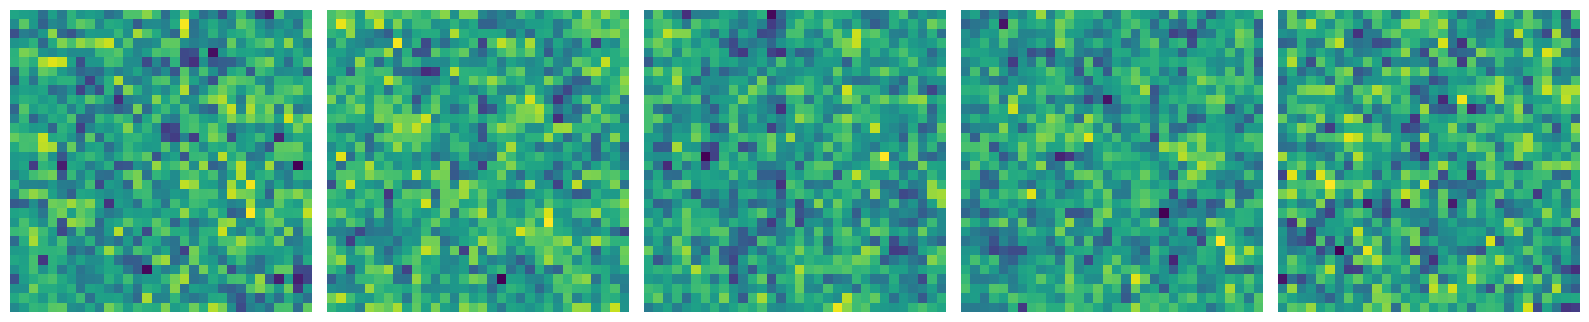

In [7]:
L = 32
k = 0.3
l = 0.02
seed = 0
key = random.PRNGKey(seed)

phi4 = Phi4(L, k, l, key=key)
cfgs = phi4.sample(num_samples=1000, hmc_steps=100, n_thin=10)
print(cfgs.shape)
cfgs = jnp.array(cfgs).reshape(-1, L, L)

# Plot 5 random configurations
fig, axes = plt.subplots(1, 5, figsize=(16, 6))  # Switched figsize to match 1 row, 5 columns
i=  10
for i, id in enumerate([1,2,3,4,5]):
    axes[i].imshow(cfgs[id], cmap='viridis')  # You can change cmap as needed
    axes[i].axis('off')  # Optional: remove axes for cleaner look
plt.tight_layout()
plt.show()

# Test Statistics

In [8]:
import jax.numpy as jnp
from jax import vmap


def jackknife(samples):
    """Return mean and estimated lower error bound."""
    n_samples = samples.shape[0]
    
    # Compute sum of all samples
    total_sum = jnp.sum(samples, axis=0)
    
    # For each jackknife sample, subtract one sample and divide by (n-1)
    # This is equivalent to computing the mean of all samples except one
    jackknife_means = (total_sum - samples) / (n_samples - 1)
    
    mean = jnp.mean(jackknife_means, axis=0)
    error = jnp.sqrt((n_samples - 1) * jnp.mean(jnp.square(jackknife_means - mean), axis=0))
    
    return mean, error


def get_mag(cfgs):
    """Return mean and error of magnetization."""
    # Compute axis tuple for spatial dimensions (all except first)
    spatial_axes = tuple(range(1, cfgs.ndim))
    mags = jnp.mean(cfgs, axis=spatial_axes)
    return jackknife(mags)


def get_abs_mag(cfgs):
    """Return mean and error of absolute magnetization."""
    spatial_axes = tuple(range(1, cfgs.ndim))
    abs_mags = jnp.abs(jnp.mean(cfgs, axis=spatial_axes))
    return jackknife(abs_mags)


def get_chi2(cfgs):
    """Return mean and error of susceptibility."""
    V = jnp.prod(jnp.array(cfgs.shape[1:]))
    spatial_axes = tuple(range(1, cfgs.ndim))
    mags = jnp.mean(cfgs, axis=spatial_axes)
    mean_mag = jnp.mean(mags)
    chi_samples = V * (mags**2 - mean_mag**2)
    return jackknife(chi_samples)


def get_corr_func(cfgs):
    """Return connected two-point correlation function with errors for symmetric lattices."""
    mag_sq = jnp.mean(cfgs)**2
    spatial_axes = tuple(range(1, cfgs.ndim))
    n_spatial_dims = cfgs.ndim - 1
    max_distance = cfgs.shape[1]  # Assuming symmetric lattice
    
    corr_func = []
    
    for i in range(1, max_distance):
        # Compute correlations for all spatial directions
        corrs_all_dirs = []
        for mu in range(n_spatial_dims):
            rolled_cfgs = jnp.roll(cfgs, i, axis=mu+1)
            corr_mu = jnp.mean(cfgs * rolled_cfgs, axis=spatial_axes)
            corrs_all_dirs.append(corr_mu)
        
        # Average over all spatial directions
        corrs_all_dirs = jnp.array(corrs_all_dirs)
        corrs = jnp.mean(corrs_all_dirs, axis=0)
        
        # Compute connected correlation function
        connected_corrs = corrs - mag_sq
        corr_mean, corr_err = jackknife(connected_corrs)
        
        corr_func.append(jnp.array([i, corr_mean, corr_err]))
    
    return jnp.array(corr_func)

M = 2.1960 +/- 0.0012
|M| = 2.1960 +/- 0.0012
chi2 = 1.4053 +/- 5.2660


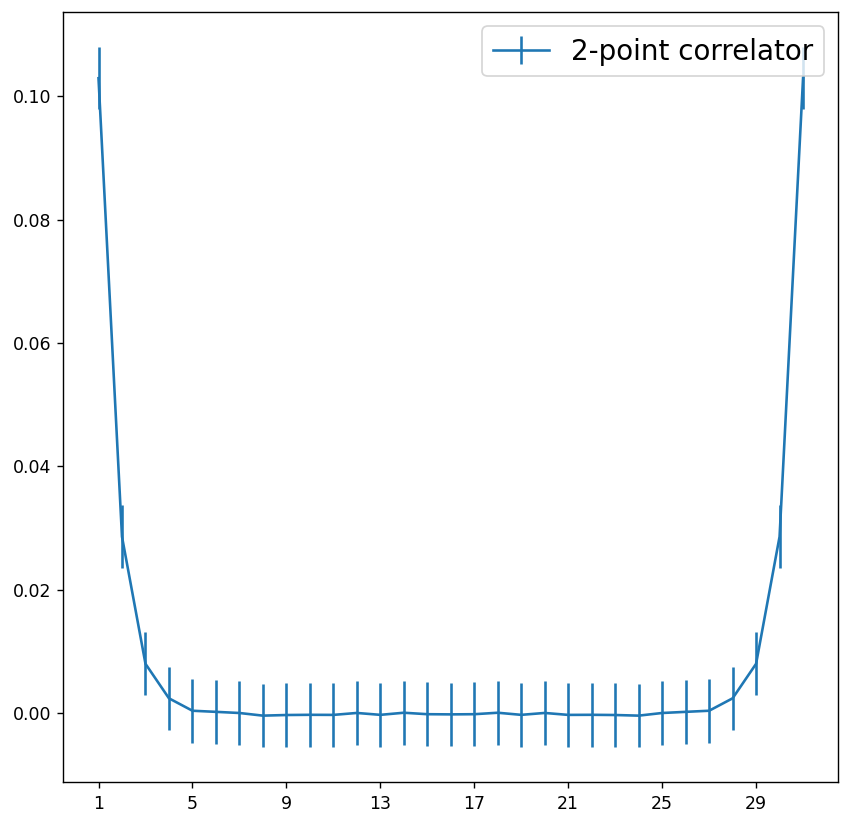

In [9]:
# Magnetization and Derivative
M, M_err = get_mag(cfgs)
M_abs, M_abs_err = get_abs_mag(cfgs)
chi2, chi2_err = get_chi2(cfgs)

print("M = %.4f +/- %.4f" % (M, M_err))
print("|M| = %.4f +/- %.4f" % (M_abs, M_abs_err))
print("chi2 = %.4f +/- %.4f" % (chi2, chi2_err))

# 2 Point Function
corr_func = get_corr_func(cfgs)

fig, ax = plt.subplots(1,1, dpi=125, figsize=(8,8))
plt.xticks([i for i in range(1, L, 4)])
ax.errorbar(corr_func[:,0], corr_func[:,1], yerr=corr_func[:,2], label='2-point correlator')
plt.legend(prop={'size': 16})
plt.show()

# Learning

In [11]:
# Construct conditional probability path
L = 32
k = 0.3
l = 0.02
seed = 0
key = random.PRNGKey(seed)

theory = Phi4(L, k, l, key=key)
dim = theory.dim
path = LinearConditionalProbabilityPath(
    p_simple = Gaussian.isotropic(dim=dim, std=1.0),
    p_data = theory,
    device = device
)

# Construct learnable vector field
linear_flow_model = MLPVectorField(dim=dim, hiddens=[64,64,64,64])

# Construct trainer
trainer = ConditionalFlowMatchingTrainer(path, linear_flow_model, device=device)
losses = trainer.train(num_epochs=10000, lr=1e-3, batch_size=1000)

Training: Epoch 706, loss: 1.1987:   7%|▋         | 707/10000 [03:15<42:54,  3.61it/s]


KeyboardInterrupt: 

In [37]:
num_marginals = 5
num_samples = 5

ode = LearnedVectorFieldODE(linear_flow_model)
simulator = EulerSimulator(ode)
ts = torch.linspace(0,1,100).to(device)
record_every_idxs = record_every(len(ts), len(ts) // (num_marginals - 1))
x0 = torch.tensor(path.p_simple.sample(num_samples)).to(device)
xts = simulator.simulate_with_trajectory(x0, ts.view(1,-1,1).expand(num_samples,-1,1))
xts = xts.reshape(xts.shape[0], xts.shape[1], L, L)[:,record_every_idxs,:,:].detach().cpu().numpy()

/var/folders/sc/49nc86fd2rg3gdc838zqh8mr0000gn/T/ipykernel_2201/457227215.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(path.p_simple.sample(num_samples)).to(device)


/var/folders/sc/49nc86fd2rg3gdc838zqh8mr0000gn/T/ipykernel_2201/4101723403.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


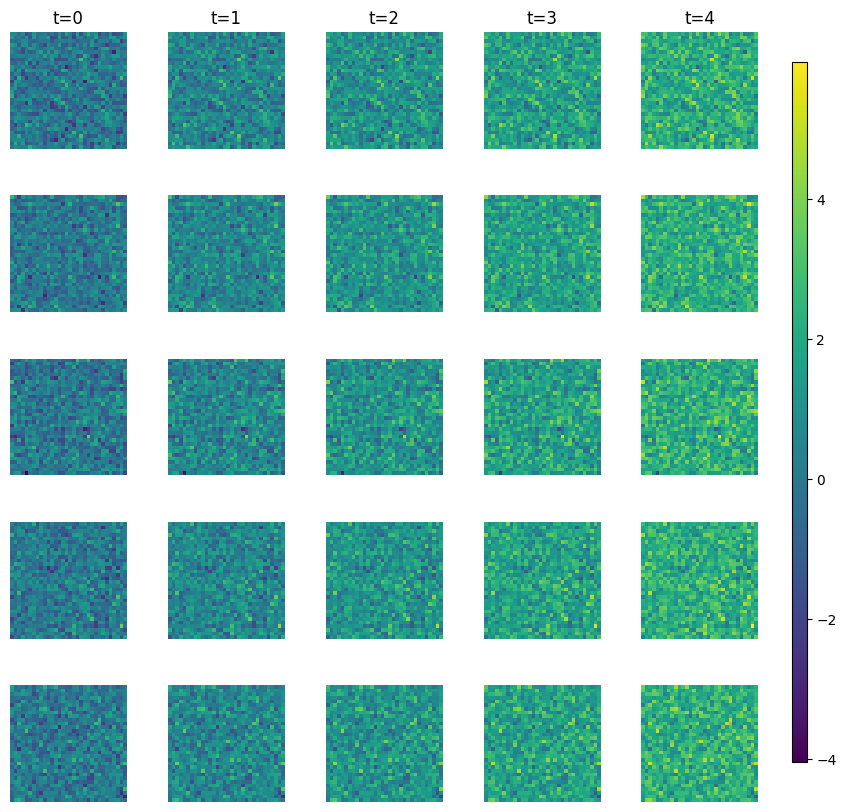

In [38]:
num_realizations, num_timesteps = xts.shape[:2]

# Determine shared color range
vmin = xts.min()
vmax = xts.max()

# Set up the figure
fig, axes = plt.subplots(
    nrows=num_realizations,
    ncols=num_timesteps,
    figsize=(2 * num_timesteps, 2 * num_realizations),
    gridspec_kw={'wspace': 0.1, 'hspace': 0.4}
)

for i in range(num_realizations):
    for j in range(num_timesteps):
        ax = axes[i, j]
        im = ax.imshow(xts[i, j], vmin=vmin, vmax=vmax, cmap='viridis')
        ax.axis('off')
        if i == 0:
            ax.set_title(f"t={j}")

# Add a colorbar on the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar
plt.show()